Run this version only if you do not have a GPU with CUDA capabilities

In [1]:
import argparse

import numpy as np
import pandas as pd
import seaborn as sns
import torch
from matplotlib import pyplot as plt
from sklearn.neural_network import MLPRegressor
from tqdm.notebook import tqdm

import data
import pytorch_lightning as pl
from ddlk import ddlk, hrt, mdn, swap, utils
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

%matplotlib inline

Set random seed for reproducibility

In [2]:
pl.trainer.seed_everything(42)

42

# Data

Create PyTorch data loaders

In [3]:
data_args = argparse.Namespace(dataset='gaussian_autoregressive_mixture',
                          n_rel=2,
                          signal_a=100,
                          d=10,
                          k=3,
                          n=2000,
                          rep=0,
                          batch_size=64)

In [4]:
# get data
trainloader, valloader, testloader = data.get_data(data_args)

# Fit DDLK

In [5]:
((X_mu, ), (X_sigma, )) = utils.get_two_moments(trainloader)

Fit `q_joint`

In [6]:
hparams = argparse.Namespace(X_mu=X_mu, X_sigma=X_sigma)

In [7]:
q_joint = mdn.MDNJoint(hparams)
trainer = pl.Trainer(max_epochs=50, num_sanity_val_steps=1, weights_summary=None, deterministic=True)
trainer.fit(q_joint,
            train_dataloader=trainloader,
            val_dataloaders=[valloader])

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
/home/sudarshan/scratch/anaconda3/envs/cuda/lib/python3.7/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)
/misc/vlgscratch4/RanganathGroup/sudarshan/bin/pytorch-lightning/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/misc/vlgscratch4/RanganathGroup/sudarshan/bin/pytorch-lightning/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch    12: reducing learning rate of group 0 to 2.5000e-04.


Epoch    20: reducing learning rate of group 0 to 2.5000e-04.


Epoch    22: reducing learning rate of group 0 to 2.5000e-04.


Epoch    23: reducing learning rate of group 0 to 2.5000e-04.


Epoch    24: reducing learning rate of group 0 to 2.5000e-04.
Epoch    24: reducing learning rate of group 0 to 2.5000e-04.


Epoch    26: reducing learning rate of group 0 to 2.5000e-04.
Epoch    26: reducing learning rate of group 0 to 2.5000e-04.


Epoch    27: reducing learning rate of group 0 to 2.5000e-04.


Epoch    33: reducing learning rate of group 0 to 1.2500e-04.


Epoch    34: reducing learning rate of group 0 to 2.5000e-04.


Epoch    35: reducing learning rate of group 0 to 1.2500e-04.


Epoch    36: reducing learning rate of group 0 to 1.2500e-04.


Epoch    39: reducing learning rate of group 0 to 1.2500e-04.
Epoch    39: reducing learning rate of group 0 to 1.2500e-04.


Epoch    40: reducing learning rate of group 0 to 1.2500e-04.


Epoch    41: reducing learning rate of group 0 to 1.2500e-04.
Epoch    41: reducing learning rate of group 0 to 1.2500e-04.


Epoch    42: reducing learning rate of group 0 to 1.2500e-04.


Epoch    46: reducing learning rate of group 0 to 6.2500e-05.


Epoch    47: reducing learning rate of group 0 to 1.2500e-04.


Epoch    48: reducing learning rate of group 0 to 6.2500e-05.


Epoch    49: reducing learning rate of group 0 to 6.2500e-05.


1

Visualize validation losses

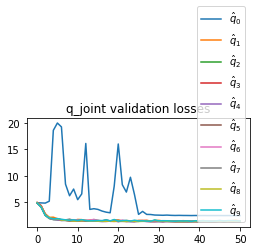

In [8]:
plt.figure(figsize=(4, 2))
plt.title('q_joint validation losses')
for j in range(X_mu.shape[-1]):
    plt.plot(q_joint.hparams.history[j]['val_loss'], label=f'$\\hat{{q}}_{{{j}}}$')
    
plt.legend()
plt.show()

Fit `q_knockoff`

In [9]:
hparams = argparse.Namespace(X_mu=X_mu, X_sigma=X_sigma)

q_knockoff = ddlk.DDLK(hparams, q_joint=q_joint)

In [10]:
trainer = pl.Trainer(max_epochs=100,
                     num_sanity_val_steps=1,
                     deterministic=True,
                     gradient_clip_val=0.5,
                     weights_summary=None)

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]


In [11]:
trainer.fit(q_knockoff,
                train_dataloader=trainloader,
                val_dataloaders=[valloader])

1

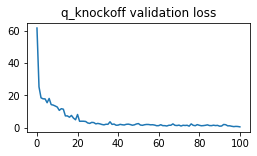

In [12]:
plt.figure(figsize=(4, 2))
plt.title('q_knockoff validation loss')
plt.plot(q_knockoff.hparams.history['val_loss'])

# Sample knockoffs

In [13]:
xTr, = utils.extract_data(trainloader)
xTr = xTr.numpy()

In [14]:
with torch.no_grad():
    xTr_tilde = q_knockoff.sample(torch.tensor(xTr)).numpy()

In [15]:
# select 2 coordinates at random
j1, j2 = np.random.permutation(10)[:2]

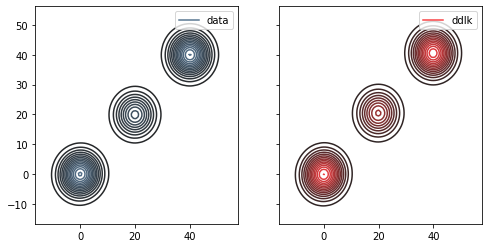

In [16]:
fig, axarr = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
sns.kdeplot(xTr[:, j1], xTr[:, j2], label='data', shade=False, levels=15, color='#577590', ax=axarr[0])
ylim = axarr[0].get_ylim()
xlim = axarr[0].get_xlim()
sns.kdeplot(xTr_tilde[:, j1], xTr_tilde[:, j2], label='ddlk', shade=False, levels=15, color='#f94144', ax=axarr[1])
axarr[1].set_xlim(*xlim)
axarr[1].set_ylim(*ylim)
axarr[0].legend()
axarr[1].legend()
plt.show()

# Perform variable selection

In [17]:
# set dataloaders to prediction mode
trainloader.dataset.set_mode('prediction')
valloader.dataset.set_mode('prediction')
testloader.dataset.set_mode('prediction')

# extract training and validation data
xTr, yTr = utils.extract_data(trainloader)
xVal, yVal = utils.extract_data(valloader)
## concatenate xTr and xVal to use in HRT
xTr = torch.cat([xTr, xVal], axis=0)
yTr = torch.cat([yTr, yVal], axis=0)
xTr = xTr.float()
xVal = xVal.float()

# extract test data
xTe, yTe = utils.extract_data(testloader)
xTe = xTe.float()

with torch.no_grad():
    xTr_tilde = q_knockoff.sample(xTr).numpy()
    xTe_tilde = q_knockoff.sample(xTe).numpy()

knockoff_test = hrt.HRT_Knockoffs(mixture_prop=0.5)

knockoff_test.fit(xTr, yTr, xTr_tilde, tqdm=tqdm)

In [18]:
knockoff_statistics = knockoff_test.score(xTe, yTe, xTe_tilde, tqdm=tqdm)

In [19]:
knockoff_statistics = pd.Series(knockoff_statistics)
results = pd.DataFrame(knockoff_statistics, columns=['statistic']).join(
    pd.DataFrame(trainloader.dataset.beta.flatten(),
                 index=np.arange(trainloader.dataset.beta.flatten().shape[0]),
                 columns=['beta']))
results.index.name = 'feature'

In [20]:
results

,statistic,beta
feature,,
0,-0.000223,0.000000
1,-0.007251,0.000000
2,0.003350,0.000000
3,1.878750,-2.236068
4,0.006014,0.000000
5,0.020428,0.000000
6,-0.008694,0.000000
7,-0.015671,0.000000
8,0.009181,0.000000
